In [1]:
# Imports and Setup
%load_ext autoreload
%autoreload 2

from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
import json
from sentence_transformers import SentenceTransformer
from transformer_lens import HookedTransformer
import utils.activation_collection as activation_collection
from eval_config import EvalConfig
import utils.dataset_utils as dataset_utils
import pandas as pd
from tqdm import tqdm, trange
import gc
import torch
from sae_lens import SAE
from sae_lens.sae import TopK
import utils.formatting_utils as formatting_utils

/share/u/can/miniconda3/envs/sem-sim-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_fname = 'adjectives_BAAI-bge-multilingual-gemma2_cosine.pkl'

# Load concepts
with open(data_fname, 'rb') as f:
    data = pd.read_pickle(f)

In [3]:
# Configuration
config = EvalConfig()
device = "cuda"
llm_batch_size = activation_collection.LLM_NAME_TO_BATCH_SIZE[config.model_name]
llm_dtype = activation_collection.LLM_NAME_TO_DTYPE[config.model_name]

In [4]:
# Initialize HookedTransformer
model = HookedTransformer.from_pretrained_no_processing(
    config.model_name, device=device, dtype=llm_dtype
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m-deduped into HookedTransformer


In [5]:
# Tokenize data and collect activations
tokenized = dataset_utils.tokenize_data(data['concepts'], model.tokenizer, config.context_length, device=device)
all_llm_acts_BLD = activation_collection.get_all_llm_activations(
    tokenized, model, llm_batch_size, config.hook_name
)
llm_acts_BD = activation_collection.create_meaned_model_activations(all_llm_acts_BLD)

Tokenizing data: 100%|██████████| 1/1 [00:00<00:00, 141.97it/s]

In [6]:
# SAE setup
selected_saes_dict = {'sae_bench_pythia70m_sweep_topk_ctx128_0730':
    ['pythia70m_sweep_topk_ctx128_0730/resid_post_layer_4/trainer_10',
    'pythia70m_sweep_topk_ctx128_0730/resid_post_layer_4/trainer_12']}

sae_release = 'sae_bench_pythia70m_sweep_topk_ctx128_0730'

sae_map_df = pd.DataFrame.from_records(
    {k: v.__dict__ for k, v in get_pretrained_saes_directory().items()}
).T

sae_id_to_name_map = sae_map_df.saes_map[sae_release]
sae_name_to_id_map = {v: k for k, v in sae_id_to_name_map.items()}

sae_name = selected_saes_dict[sae_release][0]
sae_id = sae_name_to_id_map[sae_name]

In [7]:
# Load and prepare SAE
gc.collect()
torch.cuda.empty_cache()

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release=sae_release,
    sae_id=sae_id,
    device=device,
)
sae = sae.to(device=device)

if "topk" in sae_name and not isinstance(sae.activation_fn, TopK):
    sae = formatting_utils.fix_topk_saes(sae, sae_release, sae_name, data_dir="../../")
    assert isinstance(sae.activation_fn, TopK)

In [8]:
# Get SAE activations
all_sae_acts_BF = activation_collection.get_sae_meaned_activations(
    all_llm_acts_BLD, sae, config.sae_batch_size, llm_dtype
)

# Print available keys in all_sae_train_acts_BF
print(all_sae_acts_BF.keys())

dict_keys(['adjectives'])


In [9]:
concept_name = 'adjectives'
all_sae_acts_BF[concept_name].shape

torch.Size([981, 16384])

(array([1.4608e+04, 7.4200e+02, 2.9000e+02, 1.6900e+02, 8.4000e+01,
        5.1000e+01, 5.9000e+01, 3.5000e+01, 3.7000e+01, 1.9000e+01,
        2.6000e+01, 2.6000e+01, 7.0000e+00, 1.5000e+01, 1.0000e+01,
        1.1000e+01, 9.0000e+00, 1.0000e+01, 7.0000e+00, 9.0000e+00,
        6.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 8.0000e+00,
        4.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

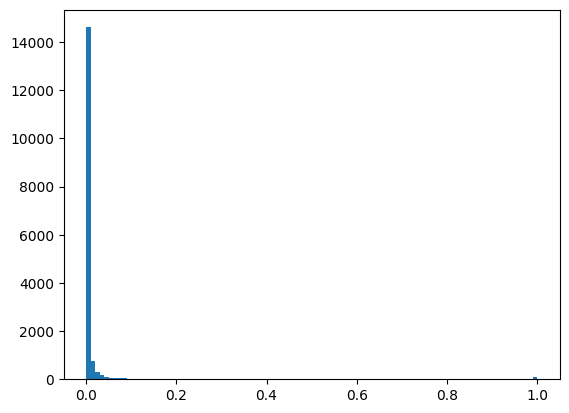

In [19]:
# activation density histogram
import matplotlib.pyplot as plt
binary_activation_BF = all_sae_acts_BF[concept_name] > 0
feature_density_F = binary_activation_BF.sum(axis=0) / all_sae_acts_BF[concept_name].shape[0]
feature_density = feature_density_F[feature_density_F > 1e-5]

plt.hist(feature_density_F.cpu().numpy(), bins=100)

In [25]:
# Compute spearman correlation between data['similarities'] of shape [W, W] and all_sae_acts_BF[concept_name] of shape [W, F]

import torch

def spearman_correlation_matrix(x, y):
    """
    Compute Spearman correlation matrix between x and y.
    x shape: [W1, F]
    y shape: [W1, W2]
    Returns: tensor of shape [W2, F]
    """
    W1, F = x.shape
    W2 = y.shape[1]
    
    # Convert to ranks
    x_rank = x.argsort(dim=0).argsort(dim=0).float()
    y_rank = y.argsort(dim=0).argsort(dim=0).float()
    
    # Center the ranks
    x_rank -= x_rank.mean(dim=0, keepdim=True)
    y_rank -= y_rank.mean(dim=0, keepdim=True)
    
    # Compute correlation
    x_std = torch.sqrt(torch.sum(x_rank**2, dim=0))
    y_std = torch.sqrt(torch.sum(y_rank**2, dim=0))
    
    corr = torch.matmul(y_rank.t(), x_rank) / (W1 - 1)
    corr /= y_std.unsqueeze(1) * x_std.unsqueeze(0)
    
    return corr

activations = all_sae_acts_BF[concept_name].to(device)
similarities = data['similarities'].to(device)

feature_batch_size = int(2**14)
spearman_correlations = []
for i in trange(0, activations.shape[1], feature_batch_size):
    spearman_correlations.append(
        spearman_correlation_matrix(
            similarities, activations[:, i:i+feature_batch_size]
        )
    )
spearman_correlations = torch.cat(spearman_correlations, dim=0)

100%|██████████| 1/1 [00:00<00:00, 1996.34it/s]


In [34]:
spearman_correlations.max()

tensor(0.0007, device='cuda:0')

(array([ 1.,  1.,  1.,  0.,  2.,  4.,  2.,  3.,  3.,  5.,  5.,  3.,  4.,
         6.,  8., 12.,  7.,  8.,  8., 11., 13., 14., 11., 10.,  9., 18.,
        19., 15., 14., 14., 11., 17., 14., 18., 17., 13., 13., 20., 27.,
        21., 13., 20., 17., 24., 14., 18., 19., 16., 23., 15., 14., 24.,
        21., 16., 18., 22., 15., 16., 15., 12., 18., 12.,  6., 12., 13.,
         6., 14., 11.,  9.,  5., 16., 13., 12.,  5.,  8.,  9.,  6.,  5.,
         7.,  4.,  4.,  6.,  1.,  1.,  2.,  2.,  1.,  2.,  4.,  3.,  4.,
         2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-4.41925573, -4.34610319, -4.27295065, -4.19979811, -4.12664509,
        -4.05349255, -3.98034   , -3.90718746, -3.83403492, -3.76088238,
        -3.68772984, -3.61457705, -3.54142451, -3.46827197, -3.39511919,
        -3.32196665, -3.24881411, -3.17566156, -3.10250902, -3.02935624,
        -2.9562037 , -2.88305116, -2.80989838, -2.73674583, -2.66359329,
        -2.59044075, -2.51728821, -2.44413543, -2.37098289, -2.297830

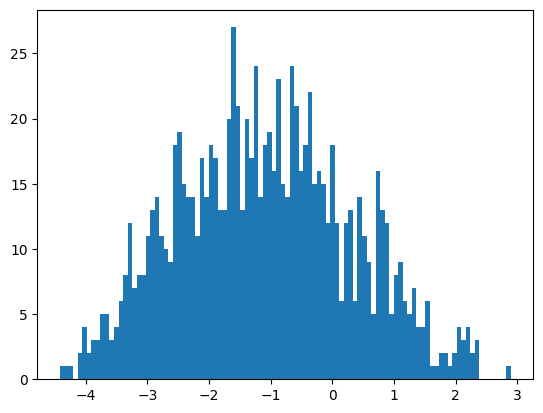

In [33]:
import matplotlib.pyplot as plt
plt.hist(spearman_correlations.sum(dim=0).cpu().numpy(), bins=100)

In [ ]:
# for each feature and each wr